In [1]:
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from pathlib import Path
sns.set_style('darkgrid', {'legend.frameon':True})

# Patterns

In [2]:
patterns = json.loads(Path('../middleware/middleware/src/regex.json').read_text(encoding='utf-8'))

In [3]:
intro_pattern = re.compile(patterns['intro'], re.I)
ctx_pattern = re.compile(patterns['ctx'], re.I)
tech_pattern = re.compile(patterns['tech'], re.I)
obs_pattern = re.compile(patterns['obs'], re.I)

In [4]:
def check_parts_integrity(x):
    text = x['cr_an']
    return [
        check_part_integrity(intro_pattern, text),
        check_part_integrity(ctx_pattern, text),
        check_part_integrity(tech_pattern, text),
        check_part_integrity(obs_pattern, text),
    ]

def check_part_integrity(pattern, text):
    return len(pattern.findall(text))

# Load

In [5]:
df = pd.read_csv('data/exports/export_CR_PETCT-01012016_an.csv', sep='\t', encoding='utf-8')
df.info()
old = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41184 entries, 0 to 41183
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NUMERO_EXAMEN   41184 non-null  object
 1   TYPE_EXAMEN     41184 non-null  object
 2   LIBELLE_EXAMEN  41184 non-null  object
 3   NUM_SALLE       41184 non-null  object
 4   DATE_EXAMEN     41184 non-null  object
 5   HEURE_EXAMEN    41184 non-null  object
 6   COMPTE_RENDU    41184 non-null  object
 7   year            41184 non-null  int64 
 8   month           41184 non-null  int64 
 9   cr_an           41184 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.1+ MB


In [6]:
integrities = df.apply(check_parts_integrity, axis=1, result_type='expand')

In [8]:
integrities.head()

,0,1,2,3
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [18]:
integrities[2].value_counts()

1    38481
2     2268
0      434
3        1
Name: 2, dtype: int64

In [25]:
df['intro'] = integrities[0] != 0
df['ctx'] = integrities[1] != 0
df['tech'] = integrities[2] != 0
df['obs'] = integrities[3] != 0
df['section_integrity'] = integrities.astype(bool).sum(axis=1) == 4
df['section_integrity'].value_counts()

True     40262
False      922
Name: section_integrity, dtype: int64

In [26]:
group_lens = []
integrity = []
intro_integrity = []
ctx_integrity = []
tech_integrity = []
obs_integrity = []

dfgb_year = df.groupby('year')
years = list(dfgb_year.groups.keys())

for k in years:
    group = dfgb_year.get_group(k)
    group_lens.append(len(group))
    integrity.append(len(group[group['section_integrity'] == False]))
    intro_integrity.append(len(group[group['intro'] == False]))
    ctx_integrity.append(len(group[group['ctx'] == False]))
    tech_integrity.append(len(group[group['tech'] == False]))
    obs_integrity.append(len(group[group['obs'] == False]))
    
group_lens = np.array(group_lens)    
years = [f'20{y}' for y in years]

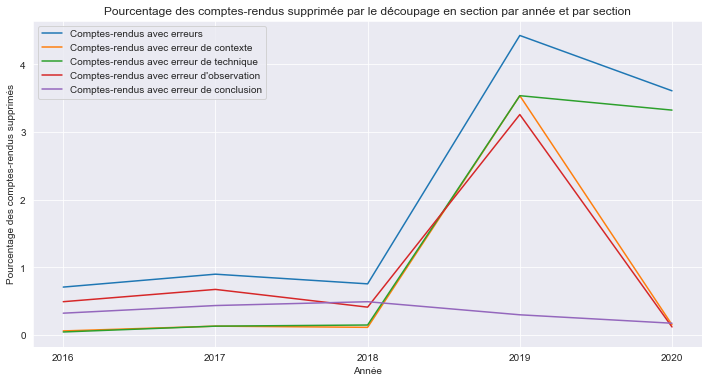

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(years, integrity / group_lens * 100, label='Comptes-rendus avec erreurs')
    ax.plot(years, intro_integrity / group_lens * 100, label='Comptes-rendus avec erreur de contexte')
ax.plot(years, ctx_integrity / group_lens * 100, label='Comptes-rendus avec erreur de technique')
ax.plot(years, tech_integrity / group_lens * 100, label='Comptes-rendus avec erreur d\'observation')
ax.plot(years, obs_integrity / group_lens * 100, label='Comptes-rendus avec erreur de conclusion')
plt.grid()
ax.set(
    xlabel='Année',
    ylabel='Pourcentage des comptes-rendus supprimés',
    title='Pourcentage des comptes-rendus supprimée par le découpage en section par année et par section')
ax.grid()
ax.legend()
plt.show()

In [ ]:
(integrities.astype(bool).sum(axis=1) - integrities[0].astype(bool)).value_counts()[4] / len(df)

In [ ]:
(integrities.astype(bool).sum(axis=1) - integrities[0].astype(bool)).value_counts()